In [23]:
#추석연휴 피쳐 변경 & 범주형 데이터는 스케일링 제외 2022.05.25

In [24]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from itertools import product # iterative combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error

# Keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU

In [25]:
### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred) # 아래 evaluation_trte를 보면 실제Y값(Y_real)을 데이터프레임으로 입력받았기 때문에 다시 array로 변환하고 flatten함, 예측Y값(Y_pred)은 array를 flatten한 값으로 입력받기때문에 추가변환 없음     
    if loss_length != 0:                                     # 잔차값 array길이가 0이 아니면 실제Y값을 길이를 줄여준다. 하지만 왜 앞에서부터 짜르지?
        Y_real = Y_real[loss_length:]                        
    if graph_on == True:                                     
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6), # 실제Y값(Y_real)은 flattenee된 array이니까 다시 데이터프레임으로 변환하고 실제값(Y_real)의 index과 동일하게 indexing하고 concat한다.
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)

In [26]:
# Data Loading
cvd19   = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/0513/cvd19_ox_0513.csv')   # 코로나
wth     = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/0513/wth_0513.csv')     # 기상 & 관광입도객(제주관광협회)
psg     = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv//0513/psg_0513.csv')     # 공합입도객수
sch     = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/0513/search_0513.csv')     # 검색량

#rnt     = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/rnt.csv')     # 렌트카
#cpt_prc = pd.read_csv('/Users/kimjinseok/Desktop/kaflix_demand forecasting/csv/cpt_prc.csv') # 경쟁사 가격
#mk_sr   = pd.read_csv('/Users/kimjinseok/Desktop/kaflix_demand forecasting/csv/mk_sr.csv')   # 시장점유율
#air_tck = pd.read_csv('/Users/kimjinseok/Desktop/kaflix_demand forecasting/csv/air_tck.csv') # 예매 가능한 비행티켓(인터파크)
#prm     = pd.read_csv('/Users/kimjinseok/Desktop/kaflix_demand forecasting/csv/prm.csv')     # 프로모션

# Datetime 
cvd19['date']=pd.to_datetime(cvd19['date'])
wth['DT']=pd.to_datetime(wth['DT'])
psg['DT']=pd.to_datetime(psg['DT'])
sch['period']=pd.to_datetime(sch['period'])
cvd19=cvd19[cvd19['location']=='South Korea']

# psg   : 2019-05-01 ~ 2022-04-28 제주공항 입도객수
# cvd19 : 2020-01-22 ~ 2022-05-12 코로나 거리두기 정책지수
# sch   : 2019-05-14 ~ 2022-05-13 '제주렌트카' 검색량
# wth   : 2017-01-01 ~ 2022-12-25 날씨 및 공휴일
# 모두 겹치는 일정 2019-05-14(코로나 제외) ~ 2022-04-28

# psg에 모든 주에 데이터 있는지 검증 => 20190-05-01부터 2022-04-28까지는 1094일
#len(psg['DT'].unique()) 

# Indexing pgs date & left join with other data
psg = psg.sort_values("DT")
psg.set_index("DT", inplace=True)
psg = psg.loc[psg.index >= '2019-05-14',:]  # 0513까지 삭제
psg = psg.groupby("DT")['ARRIVE_PPL'].sum() # 일별 입도객 합계
psg = pd.DataFrame(psg)                     # 데이터프레임만들고
cvd19.rename(columns={'date':'DT'}, inplace=True)
sch.rename(columns={'period':'DT'}, inplace=True)

# Select Required Data
cvd19 = cvd19[['DT', 'stringency_index', 'new_tests_per_thousand', 'total_vaccinations_per_hundred', 'total_boosters_per_hundred']] 
wth = wth[['DT','TEMPERTURE','RAIN','HOLIDAY_NAME']]

# merge psg & cvd19
merged = pd.merge(psg, cvd19, on="DT", how="left")

# holiday preprocessing for long and interspersed
wth_h = wth[['DT', 'HOLIDAY_NAME']]

# 1 for 'Lunar New Years' and 'Chuseok' & other holidays 
#wth_h['wth_m']=np.where((wth_h['HOLIDAY_NAME']=='설날') | (wth_h['HOLIDAY_NAME']=='추석'), 1, 0)
wth_h.HOLIDAY_NAME.loc[~wth_h.HOLIDAY_NAME.isnull()] = 1
wth_h = wth_h.sort_values('DT')
wth_h.HOLIDAY_NAME.loc[wth_h.HOLIDAY_NAME.isnull()] = 0
# wth_h['HOLIDAY_NAME']=wth_h['HOLIDAY_NAME'] + wth_h['wth_m']
# wth_h.HOLIDAY_NAME.unique()

In [27]:
# [long holidays] and [Holidays Interspersed with Workdays]
wth_h['dayofweek'] = wth_h.DT.dt.dayofweek

# 공휴일인데 금요일(4)이면 그주 금요일(4)을 연휴시작으로
# 공휴일인데 월요일(0)이면 전주 토요일(5)을 연휴시작으로
wth_h['flong']=np.where((wth_h['HOLIDAY_NAME'] == 1) & (wth_h['dayofweek'] == 4), 1, 0)
wth_h['mlong']=np.where((wth_h['HOLIDAY_NAME'] == 1) & (wth_h['dayofweek'] == 0), 1, 0)

#월요일 연휴는 그 전 토요일에 연휴 시작 표시
wth_h['mlong']= wth_h['mlong'].shift(-2)
wth_h['mlong'].fillna(method='ffill', inplace = True)

#금요일 연휴, 월요일 연휴 컬럼 합치기
wth_h['long_h']=wth_h['flong'] + wth_h['mlong'] 

#연휴시작 하루 전날 표시
wth_h['b_long_h']=wth_h['long_h'].shift(-1)
wth_h['b_long_h'].fillna(method='ffill', inplace = True)

# 징검다리 로직
# 휴일인데 목요일(3)이면 그주 목요일(3)을 징검다리 연휴시작
# 휴일인데 화요일(1)이면 전주 토요일(5)을 징검다리 연휴시작
wth_h['thinter'] = np.where((wth_h['HOLIDAY_NAME'] == 1) & (wth_h['dayofweek'] == 3), 1, 0)
wth_h['tuinter'] = np.where((wth_h['HOLIDAY_NAME'] == 1) & (wth_h['dayofweek'] == 1), 1, 0)

# 화요일 징검다리는 전주 토요일에 연휴 시작 표시
wth_h['tuinter'] = wth_h['tuinter'].shift(-3)
wth_h['tuinter'].fillna(method='ffill', inplace = True)
wth_h['inter_h'] = wth_h['thinter'] + wth_h['tuinter'] 

# 징검다리 시작 하루 전날 표시
wth_h['b_inter_h'] = wth_h['inter_h'].shift(-1)
wth_h['b_inter_h'].fillna(method='ffill', inplace = True)


In [28]:
# [first day of myeojeol] 
#holiday    : 설날/추석 명절 -> 1
#first_m    : 설날/추석 명절연휴 시작일,단 명절 연휴시작이 (일) 또는 (월)이면 (토)가 시작일 -> 1 표시
#b_first_m  : 설날/추석 명절연휴 시작일 전날, 단 명절 연휴시작이 (일) 또는 (월)이면 (금)이 시작일 전날 -> 1로 표시b

In [29]:
#first_m    : 설날/추석 명절연휴 시작일,단 명절 연휴시작이 (일) 또는 (월)이면 (토)가 시작일 -> 1 표시
#2017-01-27, 2017-10-03, 2018-02-15, 2018-09-23, 2019-02-04, 2019-09-12, 2020-01-24, 2020-09-30, 2021-02-11, 2021-09-30, 2022-02-01

#first_m_nosm   : 설날/추석 명절연휴 시작일,단 명절 연휴시작이 (화) 또는 (수) 또는 (목) 또는 (금) 또는 (토) 이면 1
wth_h['first_m_nosm']=np.where(((wth_h['DT'] == '2017-01-27') |
                          (wth_h['DT'] == '2017-10-03') |
                          (wth_h['DT'] == '2018-02-15') |
                          (wth_h['DT'] == '2018-09-23') |
                          (wth_h['DT'] == '2019-02-04') |
                          (wth_h['DT'] == '2019-09-12') |
                          (wth_h['DT'] == '2020-01-24') |
                          (wth_h['DT'] == '2020-09-30') |
                          (wth_h['DT'] == '2021-02-11') |
                          (wth_h['DT'] == '2021-09-20') |
                          (wth_h['DT'] == '2022-01-31') )
                          & ((wth_h['dayofweek'] != 6) & (wth_h['dayofweek'] !=0)), 1,0)

#first_m_s   : 설날/추석 명절연휴 시작일,단 명절 연휴시작이 (일)이면 1로 표시하고 shift -1
wth_h['first_m_s']=np.where(((wth_h['DT'] == '2017-01-27') |
                          (wth_h['DT'] == '2017-10-03') |
                          (wth_h['DT'] == '2018-02-15') |
                          (wth_h['DT'] == '2018-09-23') |
                          (wth_h['DT'] == '2019-02-04') |
                          (wth_h['DT'] == '2019-09-12') |
                          (wth_h['DT'] == '2020-01-24') |
                          (wth_h['DT'] == '2020-09-30') |
                          (wth_h['DT'] == '2021-02-11') |
                          (wth_h['DT'] == '2021-09-20') |
                          (wth_h['DT'] == '2022-01-31') )
                          & (wth_h['dayofweek'] == 6), 1,0)
wth_h['first_m_s'] = wth_h['first_m_s'].shift(-1)
wth_h['first_m_s'].fillna(method='ffill', inplace = True)

#first_m_m   : 설날/추석 명절연휴 시작일,단 명절 연휴시작이 (월)이면 1로 표시하고 shift -2
wth_h['first_m_m']=np.where(((wth_h['DT'] == '2017-01-27') |
                          (wth_h['DT'] == '2017-10-03') |
                          (wth_h['DT'] == '2018-02-15') |
                          (wth_h['DT'] == '2018-09-23') |
                          (wth_h['DT'] == '2019-02-04') |
                          (wth_h['DT'] == '2019-09-12') |
                          (wth_h['DT'] == '2020-01-24') |
                          (wth_h['DT'] == '2020-09-30') |
                          (wth_h['DT'] == '2021-02-11') |
                          (wth_h['DT'] == '2021-09-20') |
                          (wth_h['DT'] == '2022-01-31') )
                          & (wth_h['dayofweek'] == 0), 1,0)
wth_h['first_m_m'] = wth_h['first_m_m'].shift(-2)
wth_h['first_m_m'].fillna(method='ffill', inplace = True)

wth_h['first_m'] = wth_h['first_m_nosm'] + wth_h['first_m_s'] + wth_h['first_m_m']

wth_h['b_first_m'] = wth_h['first_m'].shift(-1)
wth_h['b_first_m'].fillna(method='ffill', inplace=True)


In [30]:
wth_h.columns

Index(['DT', 'HOLIDAY_NAME', 'dayofweek', 'flong', 'mlong', 'long_h',
       'b_long_h', 'thinter', 'tuinter', 'inter_h', 'b_inter_h',
       'first_m_nosm', 'first_m_s', 'first_m_m', 'first_m', 'b_first_m'],
      dtype='object')

In [31]:
wth_h.drop(['flong', 'mlong', 'thinter','tuinter', 'first_m_nosm','first_m_s', 'first_m_m'], axis=1, inplace=True)

In [32]:
# merge wether & searching data 
wth=wth[['DT','TEMPERTURE','RAIN']]
wth=pd.merge(wth, wth_h, how='left', on='DT')
merged=pd.merge(merged, wth, on="DT", how="left")
merged=pd.merge(merged, sch, on='DT', how='left')
merged


# columns rename
merged.columns = ['datetime' , 'count', 'cvd_index', 'new_test', 'total_vaccin', 'total_booster' ,'temperature', 'rain', 'holiday', 'dayofweek','long_h','b_long_h','inter_h','b_inter_h','first_m','b_first_m','search']

# nan to zero
cvd_cols = ['cvd_index', 'new_test', 'total_vaccin', 'total_booster']
merged[cvd_cols] = merged[cvd_cols].replace({np.nan:0})

In [34]:
# feature engineering for time-series
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['DateTime'] = pd.to_datetime(raw['datetime'])
    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    # decompose trend / seasonal data 
    decompose=sm.tsa.seasonal_decompose(raw['count'], model='additive')
    decompose.plot()

    # add trend data 
    Y_trend=pd.DataFrame(decompose.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns=['count_trend']
    raw = pd.concat([raw, Y_trend], axis=1)
    
    # add seasonal data 
    Y_seasonal = pd.DataFrame(decompose.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns=['count_seasonal']
    raw = pd.concat([raw, Y_seasonal], axis=1)
    
    # add weekly data 
    Y_count_Week = raw[['count']].rolling(7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns=['count_Week']
    raw = pd.concat([raw, Y_count_Week], axis=1)
    
    # add difference data 
    Y_diff = raw[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    raw = pd.concat([raw, Y_diff], axis=1)

    # add time series data 
    raw['year']       = raw.datetime.dt.year
    raw['quarter']    = raw.datetime.dt.quarter
    raw['month']      = raw.datetime.dt.month
    raw['count_lag1'] = raw['count']#.shift(1)
    #raw['count_lag1'].fillna(method = 'bfill', inplace=True)
    raw['count_lag2'] = raw['count']#.shift(2)
    #raw['count_lag2'].fillna(method = 'bfill', inplace=True)


    # dummy 변수(카테고리 변수) => holiday(0,1) / dayofweek(0,1,2,3,4,5,6) / long_h(0,1) / b_long_h(0,1) / inter_h(0,1) / b_inter_h(0,1) 
    #                         /first_m(0,1)/ b_first_m(0,1) / year(2019,2020,2021,2022) / month(1~12) / quarter(1~4)

    raw = pd.concat([raw, pd.get_dummies(raw['holiday'],   prefix='holiday'   + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['dayofweek'], prefix='dayofweek' + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['long_h'],    prefix='long_h'    + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['b_long_h'],  prefix='b_long_h'  + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['inter_h'],   prefix='inter_h'   + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['b_inter_h'], prefix='b_inter_h' + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['first_m'],   prefix='first_m'   + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['b_first_m'], prefix='b_first_m' + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['year'],      prefix='year'      + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['month'],     prefix='month'     + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['quarter'],   prefix='quarter'   + '_dummy')], axis=1)

    raw = raw.drop(columns=['holiday', 'dayofweek', 'long_h', 'b_long_h', 'inter_h', 'b_inter_h','first_m','b_first_m', 'year', 'month', 'quarter'])
    
    raw_fe = raw.copy() 
    return raw_fe

# Reality _ feature_engineering_year_duplicated
# target = ['count_trend', 'count_seasonal', 'count_Week', 'count_diff']
def feature_engineering_year_duplicated(raw, target):
    raw_feRD = raw.copy()
    for col in target:
        raw_feRD.loc['2021-04-29':'2022-04-28', col] = raw_feRD.loc['2020-04-29':'2021-04-28', col].values
    return raw_feRD

# Data Split for time series to train & test
def datasplit_ts(raw, criteria):
    raw_train = raw.loc[merged.index < criteria, :]
    raw_test  = raw.loc[merged.index >= criteria, :]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    return raw_train, raw_test

# Y_colname = ['count']
# X_remove = ['datetime', 'DateTime']
# X_colname = [x for x in merged.columns if x not in Y_colname + X_remove]

# Data Split for Y_train, X_train
def datasplit_train(train, Y_colname, X_colname):
    X_colname = [x for x in train.columns if x not in Y_colname + X_remove]
    Y_train = train[Y_colname]
    X_train = train[X_colname]
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    return X_train, Y_train

# Data Split for Y_train, X_train
def datasplit_test(test, Y_colname, X_colname):
    X_colname = [x for x in test.columns if x not in Y_colname + X_remove]
    Y_test = test[Y_colname]
    X_test = test[X_colname]
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_test, Y_test


# modify lagged values of X_test
# target = ['count_lag1', 'count_lag2']
def feature_engineering_lag_modified(Y, X, target):
    X_lm = X.copy()
    i = 1
    for col in target:
        X_lm[col] = Y.shift(i).values
        X_lm[col].fillna(method='bfill', inplace=True)
        i = i + 1
    return X_lm

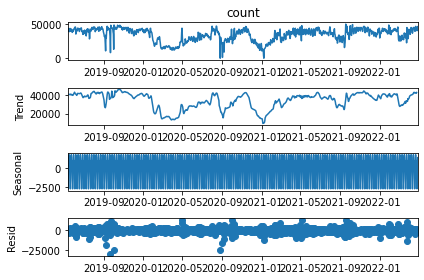

In [35]:
# Feature Engineering
merged_fe  = feature_engineering(merged)

In [36]:
# Reality _ feature_engineering_year_duplicated
target_d  = ['count_trend', 'count_seasonal', 'count_Week', 'count_diff']
merged_feRD = feature_engineering_year_duplicated(merged_fe, target_d)

In [37]:
# Data Split for time series to train & test
Train, Test = datasplit_ts(merged_feRD, '2022-02-28')

Train_size: (1021, 56) Test_size: (60, 56)


In [38]:
Y_colname = ['count']
X_remove = ['datetime', 'DateTime']
X_colname = [x for x in merged.columns if x not in Y_colname + X_remove]

# Data Split to X and Y
X_train, Y_train = datasplit_train(Train,Y_colname, X_colname)
X_test, Y_test = datasplit_test(Test,Y_colname, X_colname)

X_train: (1021, 54) Y_train: (1021, 1)
X_test: (60, 54) Y_test: (60, 1)


In [39]:
# Reality _ modify lagged values of X_train
target_l = ['count_lag1', 'count_lag2']
X_train = feature_engineering_lag_modified(Y_train, X_train, target_l)

In [40]:
# Reality _ modify lagged values of X_test
target_l = ['count_lag1', 'count_lag2']
X_test = feature_engineering_lag_modified(Y_test, X_test, target_l)

In [41]:
continous_feature=['cvd_index', 'new_test', 'total_vaccin', 'total_booster', 'temperature',
                   'rain', 'search', 'count_trend', 'count_seasonal', 'count_Week',
                   'count_diff', 'count_lag1', 'count_lag2']

In [42]:
category_feature=['holiday_dummy_0','holiday_dummy_1', 'dayofweek_dummy_0',
                  'dayofweek_dummy_1', 'dayofweek_dummy_2', 'dayofweek_dummy_3','dayofweek_dummy_4',
                  'dayofweek_dummy_5', 'dayofweek_dummy_6','long_h_dummy_0.0', 'long_h_dummy_1.0',
                  'b_long_h_dummy_0.0','b_long_h_dummy_1.0', 'inter_h_dummy_0.0', 'inter_h_dummy_1.0',
                  'b_inter_h_dummy_0.0', 'b_inter_h_dummy_1.0', 'first_m_dummy_0.0', 'first_m_dummy_1.0',
                  'b_first_m_dummy_0.0', 'b_first_m_dummy_1.0', 'year_dummy_2019', 'year_dummy_2020', 
                  'year_dummy_2021','year_dummy_2022', 'month_dummy_1', 'month_dummy_2', 'month_dummy_3',
                  'month_dummy_4', 'month_dummy_5', 'month_dummy_6', 'month_dummy_7','month_dummy_8',
                  'month_dummy_9', 'month_dummy_10', 'month_dummy_11','month_dummy_12', 'quarter_dummy_1', 
                  'quarter_dummy_2','quarter_dummy_3', 'quarter_dummy_4']

In [43]:
# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
batch_size = 32
epoch = 30
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_con = scaler_X_tr.fit_transform(X_train[continous_feature])
X_train_cat = X_train[category_feature].to_numpy()
X_train_mlp = np.concatenate((X_train_con, X_train_cat), axis=1)
Y_train_mlp = scaler_Y_tr.fit_transform(Y_train)

X_test_con = scaler_X_tr.transform(X_test[continous_feature])
X_test_cat = X_test[category_feature].to_numpy()
X_test_mlp = np.concatenate((X_test_con, X_test_cat), axis=1)
Y_test_mlp = scaler_Y_tr.transform(Y_test)

print('X_train_mlp:', X_train_mlp.shape, 'Y_train_mlp:', Y_train_mlp.shape)
print('X_test_mlp:', X_test_mlp.shape, 'Y_test_mlp:', Y_test_mlp.shape)

X_train_mlp: (1021, 54) Y_train_mlp: (1021, 1)
X_test_mlp: (60, 54) Y_test_mlp: (60, 1)


# MLP

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               7040      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)          

2022-06-08 13:13:36.711275: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-08 13:13:36.711369: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/30


2022-06-08 13:13:36.927568: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 1/32 [..............................] - ETA: 13s - loss: 0.2136

2022-06-08 13:13:37.172599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step - loss: 0.0292
Epoch 2/30
32/32 [==============================] - 0s 9ms/step - loss: 0.0066
Epoch 3/30
32/32 [==============================] - 0s 11ms/step - loss: 0.0047
Epoch 4/30
32/32 [==============================] - 0s 10ms/step - loss: 0.0033
Epoch 5/30
32/32 [==============================] - 0s 10ms/step - loss: 0.0031
Epoch 6/30
32/32 [==============================] - 0s 9ms/step - loss: 0.0025
Epoch 7/30
32/32 [==============================] - 0s 8ms/step - loss: 0.0027
Epoch 8/30
32/32 [==============================] - 0s 7ms/step - loss: 0.0026
Epoch 9/30
32/32 [==============================] - 0s 9ms/step - loss: 0.0024
Epoch 10/30
32/32 [==============================] - 0s 11ms/step - loss: 0.0017
Epoch 11/30
32/32 [==============================] - 0s 11ms/step - loss: 0.0015
Epoch 12/30
32/32 [==============================] - 0s 11ms/step - loss: 0.0016
Epoch 13/30
32/32 [==============================] - 

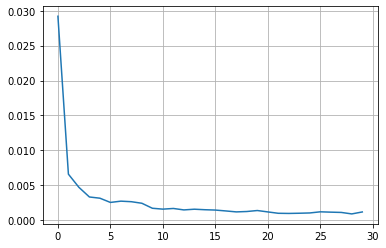

2022-06-08 13:13:47.133269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 20ms/step - loss: 0.0000e+00


2022-06-08 13:13:47.394594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,MAE,MSE,MAPE
Train,"1,117.63","2,074,957.92",inf
Test,"5,276.65","40,854,419.93",17.05


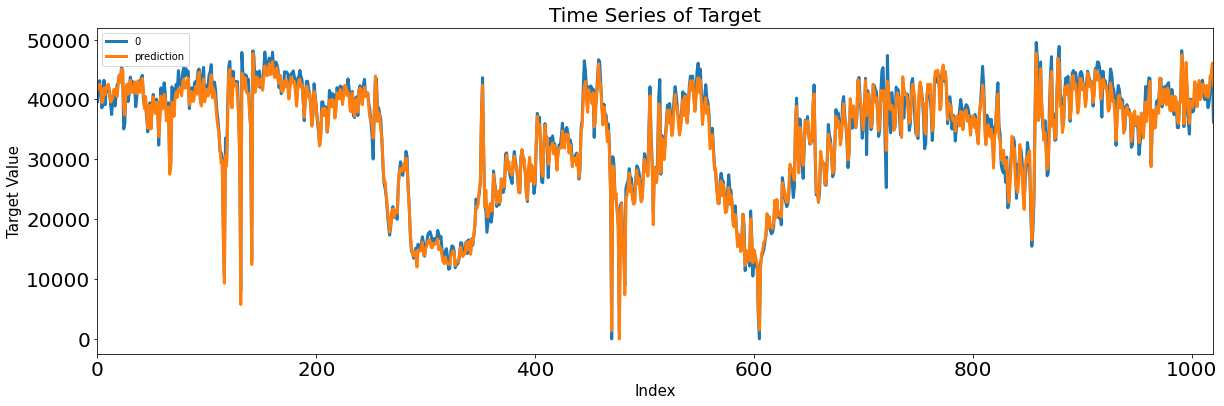

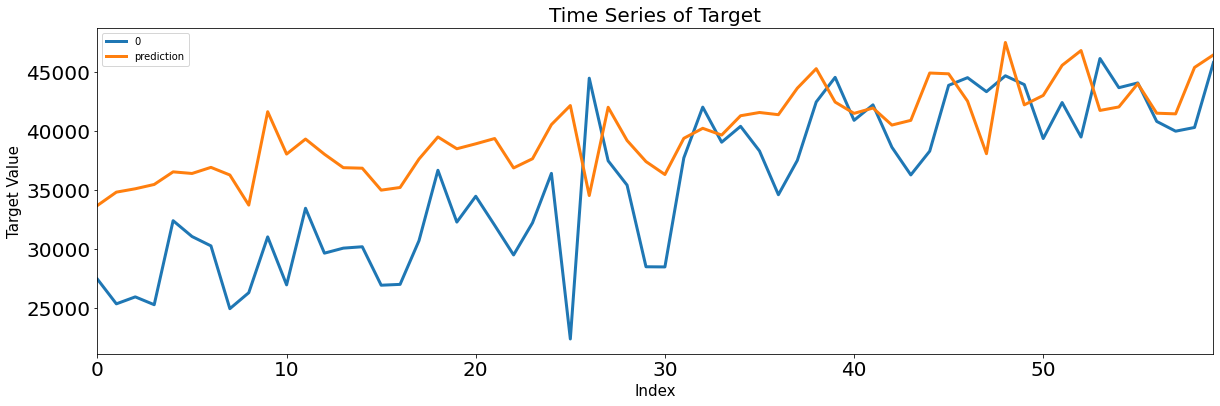

In [44]:
model = Sequential()
model.add(Dense(128, input_shape=(X_train_mlp.shape[1],), activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit_mlp = model.fit(X_train_mlp, Y_train_mlp, batch_size=batch_size, epochs=epoch, verbose = verbose)
plt.plot(pd.DataFrame(model_fit_mlp.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred_mlp = model.predict(X_train_mlp)
Y_test_pred_mlp = model.predict(X_test_mlp)

# evaluation
result_mlp = model.evaluate(X_test_mlp, Y_test_pred_mlp)
if scaler_Y_tr != []:
    Y_train_mlp = scaler_Y_tr.inverse_transform(Y_train_mlp)
    Y_train_pred_mlp = scaler_Y_tr.inverse_transform(Y_train_pred_mlp)
    Y_test_mlp = scaler_Y_tr.inverse_transform(Y_test_mlp)
    Y_test_pred_mlp = scaler_Y_tr.inverse_transform(Y_test_pred_mlp)
Score_MLP, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train_mlp), Y_train_pred_mlp.flatten(), 
                                                      pd.DataFrame(Y_test_mlp), Y_test_pred_mlp.flatten(), graph_on=True)
display(Score_MLP)

# RNN

## sequence=1

In [45]:
# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
# sequence = 24
batch_size = 32
epoch = 40
verbose = 1
dropout_ratio = 0.2

# Feature Engineering
## Scaling
X_train_rnn1 = scaler_X_tr.fit_transform(X_train)
Y_train_rnn1 = scaler_Y_tr.fit_transform(Y_train)
X_test_rnn1 = scaler_X_tr.transform(X_test)
Y_test_rnn1 = scaler_Y_tr.transform(Y_test)

## Retype and Reshape
X_train_rnn1 = X_train_rnn1.reshape(X_train_rnn1.shape[0], 1, X_train_rnn1.shape[1])
X_test_rnn1 = X_test_rnn1.reshape(X_test_rnn1.shape[0], 1, X_test_rnn1.shape[1])
print('X_train_rnn1:', X_train_rnn1.shape, 'Y_train_rnn1:', Y_train_rnn1.shape)
print('X_test_rnn1:', X_test_rnn1.shape, 'Y_test_rnn1:', Y_test_rnn1.shape)

X_train_rnn1: (1021, 1, 54) Y_train_rnn1: (1021, 1)
X_test_rnn1: (60, 1, 54) Y_test_rnn1: (60, 1)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 128)            23424     
                                                                 
 dropout_4 (Dropout)         (None, 1, 128)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 1, 256)            98560     
                                                                 
 dropout_5 (Dropout)         (None, 1, 256)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 1, 128)            49280     
                                                                 
 dropout_6 (Dropout)         (None, 1, 128)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 1, 64)            

2022-06-08 13:13:49.763437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 4s 59ms/step - loss: 0.0485
Epoch 2/40
32/32 [==============================] - 2s 54ms/step - loss: 0.0156
Epoch 3/40
32/32 [==============================] - 2s 61ms/step - loss: 0.0115
Epoch 4/40
32/32 [==============================] - 2s 60ms/step - loss: 0.0086
Epoch 5/40
32/32 [==============================] - 2s 49ms/step - loss: 0.0077
Epoch 6/40
32/32 [==============================] - 2s 58ms/step - loss: 0.0071
Epoch 7/40
32/32 [==============================] - 2s 60ms/step - loss: 0.0072
Epoch 8/40
32/32 [==============================] - 2s 56ms/step - loss: 0.0060
Epoch 9/40
32/32 [==============================] - 2s 61ms/step - loss: 0.0060
Epoch 10/40
32/32 [==============================] - 2s 63ms/step - loss: 0.0051
Epoch 11/40
32/32 [==============================] - 2s 63ms/step - loss: 0.0049
Epoch 12/40
32/32 [==============================] - 2s 53ms/step - loss: 0.0041
Epoch 13/40
32/32 [=============================

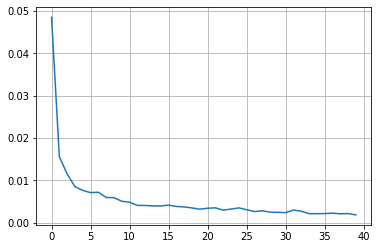

2022-06-08 13:15:04.625638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 37ms/step - loss: 0.0000e+00


2022-06-08 13:15:05.812540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,MAE,MSE,MAPE
Train,"4,408.89","22,412,430.10",inf
Test,"3,497.19","19,819,364.24",10.70


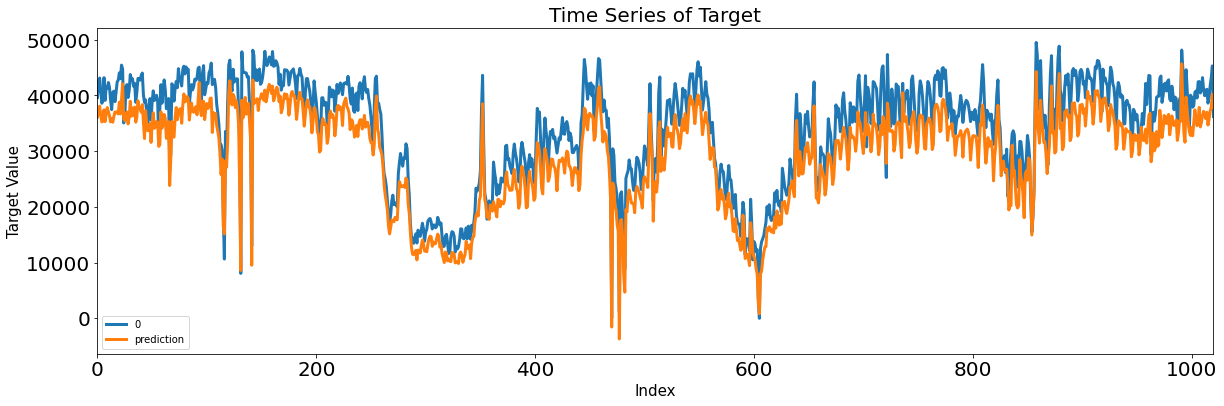

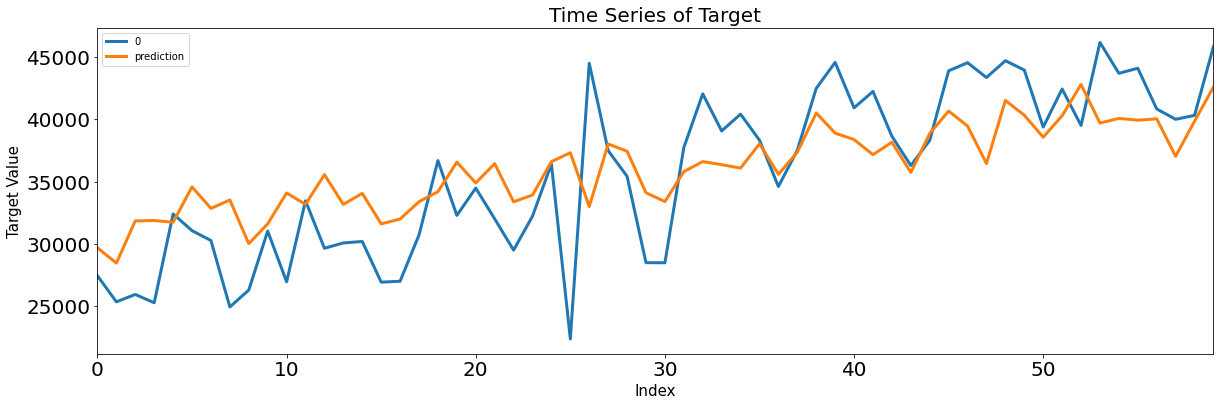

In [46]:
# RNN
model = Sequential()
model.add(SimpleRNN(128, input_shape=(X_train_rnn1.shape[1], X_train_rnn1.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(64, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit_rnn1 = model.fit(X_train_rnn1, Y_train_rnn1, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit_rnn1.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred_rnn1 = model.predict(X_train_rnn1)
Y_test_pred_rnn1 = model.predict(X_test_rnn1)

# evaluation
result_rnn1 = model.evaluate(X_test_rnn1, Y_test_pred_rnn1)
if scaler_Y_tr != []:
    Y_train_rnn1 = scaler_Y_tr.inverse_transform(Y_train_rnn1)
    Y_train_pred_rnn1 = scaler_Y_tr.inverse_transform(Y_train_pred_rnn1)
    Y_test_rnn1 = scaler_Y_tr.inverse_transform(Y_test_rnn1)
    Y_test_pred_rnn1 = scaler_Y_tr.inverse_transform(Y_test_pred_rnn1)
Score_RNN1, Residual_tr_rnn1, Residual_te_rnn1 = evaluation_trte(pd.DataFrame(Y_train_rnn1), Y_train_pred_rnn1.flatten(), 
                                                      pd.DataFrame(Y_test_rnn1), Y_test_pred_rnn1.flatten(), graph_on=True)
display(Score_RNN1)

## sequence = 24

In [47]:
# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 24
batch_size = 32
epoch = 40
verbose = 1
dropout_ratio = 0.2

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

## X / Y Split
X_train_rnn24, Y_train_rnn24 = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train_rnn24.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train_rnn24.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train_rnn24, Y_train_rnn24 = np.array(X_train_rnn24), np.array(Y_train_rnn24)
X_test_rnn24, Y_test_rnn24 = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test_rnn24.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test_rnn24.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test_rnn24, Y_test_rnn24 = np.array(X_test_rnn24), np.array(Y_test_rnn24) 

print('X_train:', X_train_rnn24.shape, 'Y_train:', Y_train_rnn24.shape)
print('X_test:', X_test_rnn24.shape, 'Y_test:', Y_test_rnn24.shape)


## Retype and Reshape
X_train_rnn24 = X_train_rnn24.reshape(X_train_rnn24.shape[0], sequence, -1)
X_test_rnn24 = X_test_rnn24.reshape(X_test_rnn24.shape[0], sequence, -1)
print('X_train_rnn24:', X_train_rnn24.shape, 'Y_train_rnn24:', Y_train_rnn24.shape)
print('X_test_rnn24:', X_test_rnn24.shape, 'Y_test_rnn24:', Y_test_rnn24.shape)

X_train: (997, 24, 54) Y_train: (997, 1)
X_test: (36, 24, 54) Y_test: (36, 1)
X_train_rnn24: (997, 24, 54) Y_train_rnn24: (997, 1)
X_test_rnn24: (36, 24, 54) Y_test_rnn24: (36, 1)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 24, 128)           23424     
                                                                 
 dropout_8 (Dropout)         (None, 24, 128)           0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 24, 256)           98560     
                                                                 
 dropout_9 (Dropout)         (None, 24, 256)           0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 24, 128)           49280     
                                                                 
 dropout_10 (Dropout)        (None, 24, 128)           0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 24, 64)           

2022-06-08 13:15:08.228405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 68s 2s/step - loss: 0.0766
Epoch 2/40
32/32 [==============================] - 65s 2s/step - loss: 0.0230
Epoch 3/40
32/32 [==============================] - 65s 2s/step - loss: 0.0150
Epoch 4/40
32/32 [==============================] - 65s 2s/step - loss: 0.0138
Epoch 5/40
32/32 [==============================] - 91s 3s/step - loss: 0.0116
Epoch 6/40
32/32 [==============================] - 96s 3s/step - loss: 0.0103
Epoch 7/40
32/32 [==============================] - 97s 3s/step - loss: 0.0101
Epoch 8/40
32/32 [==============================] - 98s 3s/step - loss: 0.0110
Epoch 9/40
32/32 [==============================] - 97s 3s/step - loss: 0.0096
Epoch 10/40
32/32 [==============================] - 99s 3s/step - loss: 0.0088
Epoch 11/40
32/32 [==============================] - 99s 3s/step - loss: 0.0092
Epoch 12/40
32/32 [==============================] - 97s 3s/step - loss: 0.0082
Epoch 13/40
32/32 [==============================] - 97s 3s/

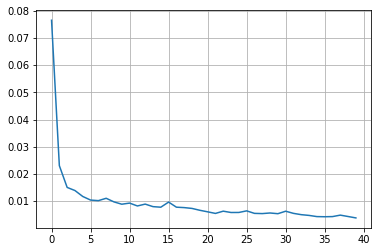

2022-06-08 14:18:22.723871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-08 14:18:38.218000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 369ms/step - loss: 0.0000e+00


,MAE,MSE,MAPE
Train,"3,019.03","13,174,843.24",inf
Test,"4,075.57","26,849,352.80",10.97


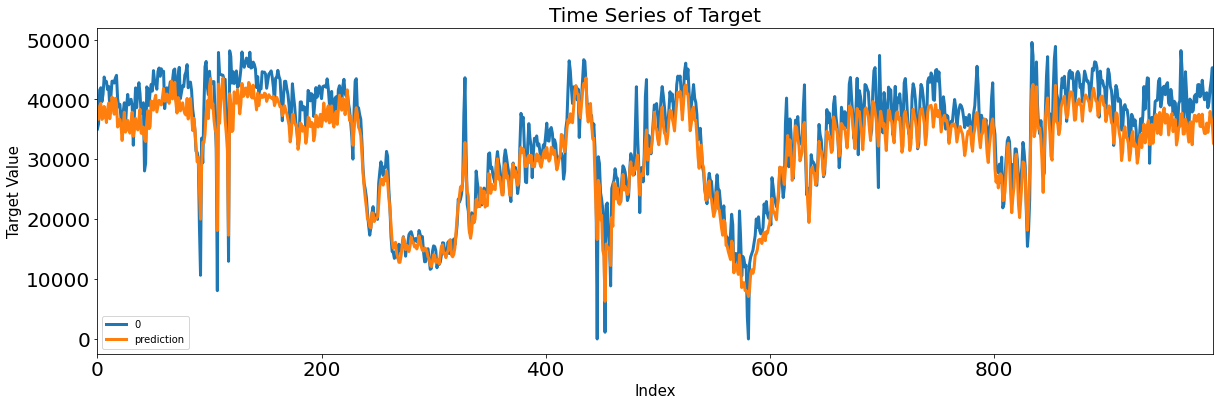

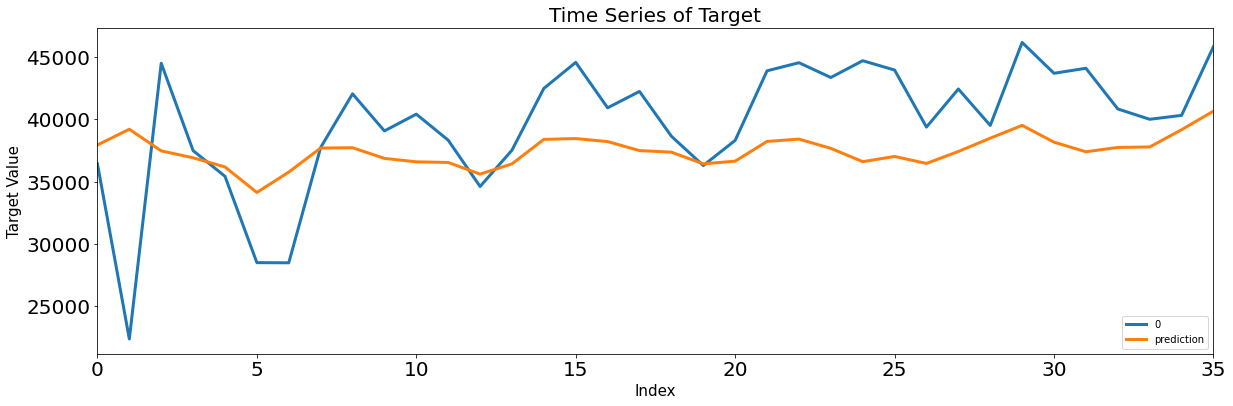

In [48]:
# RNN
model = Sequential()
model.add(SimpleRNN(128, input_shape=(X_train_rnn24.shape[1], X_train_rnn24.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(64, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit_rnn24 = model.fit(X_train_rnn24, Y_train_rnn24, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit_rnn24.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred_rnn24 = model.predict(X_train_rnn24)
Y_test_pred_rnn24 = model.predict(X_test_rnn24)

# evaluation
result_rnn24 = model.evaluate(X_test_rnn24, Y_test_pred_rnn24)
if scaler_Y_tr != []:
    Y_train_rnn24 = scaler_Y_tr.inverse_transform(Y_train_rnn24)
    Y_train_pred_rnn24 = scaler_Y_tr.inverse_transform(Y_train_pred_rnn24)
    Y_test_rnn24 = scaler_Y_tr.inverse_transform(Y_test_rnn24)
    Y_test_pred_rnn24 = scaler_Y_tr.inverse_transform(Y_test_pred_rnn24)
Score_RNN24, Residual_tr_rnn24, Residual_te_rnn24 = evaluation_trte(pd.DataFrame(Y_train_rnn24), Y_train_pred_rnn24.flatten(), 
                                                      pd.DataFrame(Y_test_rnn24), Y_test_pred_rnn24.flatten(), graph_on=True)
display(Score_RNN24)

# LSTM

In [49]:
# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 24
batch_sizBe = 32
epoch = 40
verbose = 1
dropout_ratio = 0.2

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

## X / Y Split
X_train_lstm, Y_train_lstm = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train_lstm.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train_lstm.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train_lstm, Y_train_lstm = np.array(X_train_lstm), np.array(Y_train_lstm)
X_test_lstm, Y_test_lstm = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test_lstm.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test_lstm.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test_lstm, Y_test_lstm = np.array(X_test_lstm), np.array(Y_test_lstm) 

print('X_train_lstm:', X_train_lstm.shape, 'Y_train_lstm:', Y_train_lstm.shape)
print('X_test_lstm:', X_test_lstm.shape, 'Y_test_lstm:', Y_test_lstm.shape)


## Retype and Reshape
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], sequence, -1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], sequence, -1)
print('X_train_lstm:', X_train_lstm.shape, 'Y_train_lstm:', Y_train_lstm.shape)
print('X_test_lstm:', X_test_lstm.shape, 'Y_test_lstm:', Y_test_lstm.shape)

X_train_lstm: (997, 24, 54) Y_train_lstm: (997, 1)
X_test_lstm: (36, 24, 54) Y_test_lstm: (36, 1)
X_train_lstm: (997, 24, 54) Y_train_lstm: (997, 1)
X_test_lstm: (36, 24, 54) Y_test_lstm: (36, 1)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 128)           93696     
                                                                 
 dropout_12 (Dropout)        (None, 24, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 24, 256)           394240    
                                                                 
 dropout_13 (Dropout)        (None, 24, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 24, 128)           197120    
                                                                 
 dropout_14 (Dropout)        (None, 24, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)               

2022-06-08 14:18:46.119112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 199s 6s/step - loss: 0.2227
Epoch 2/40
32/32 [==============================] - 196s 6s/step - loss: 0.0273
Epoch 3/40
32/32 [==============================] - 190s 6s/step - loss: 0.0163
Epoch 4/40
32/32 [==============================] - 191s 6s/step - loss: 0.0129
Epoch 5/40
32/32 [==============================] - 191s 6s/step - loss: 0.0118
Epoch 6/40
32/32 [==============================] - 155s 5s/step - loss: 0.0112
Epoch 7/40
32/32 [==============================] - 194s 6s/step - loss: 0.0140
Epoch 8/40
32/32 [==============================] - 192s 6s/step - loss: 0.0099
Epoch 9/40
32/32 [==============================] - 155s 5s/step - loss: 0.0099
Epoch 10/40
32/32 [==============================] - 126s 4s/step - loss: 0.0100
Epoch 11/40
32/32 [==============================] - 127s 4s/step - loss: 0.0088
Epoch 12/40
32/32 [==============================] - 127s 4s/step - loss: 0.0095
Epoch 13/40
32/32 [=============================

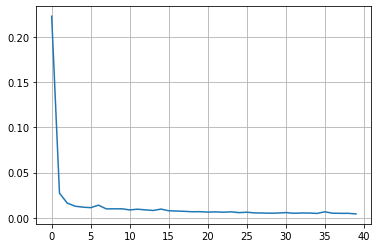

2022-06-08 15:42:03.975129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-08 15:42:09.193172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 192ms/step - loss: 0.0000e+00


,MAE,MSE,MAPE
Train,"4,004.65","22,703,903.57",inf
Test,"4,040.45","24,833,974.86",10.78


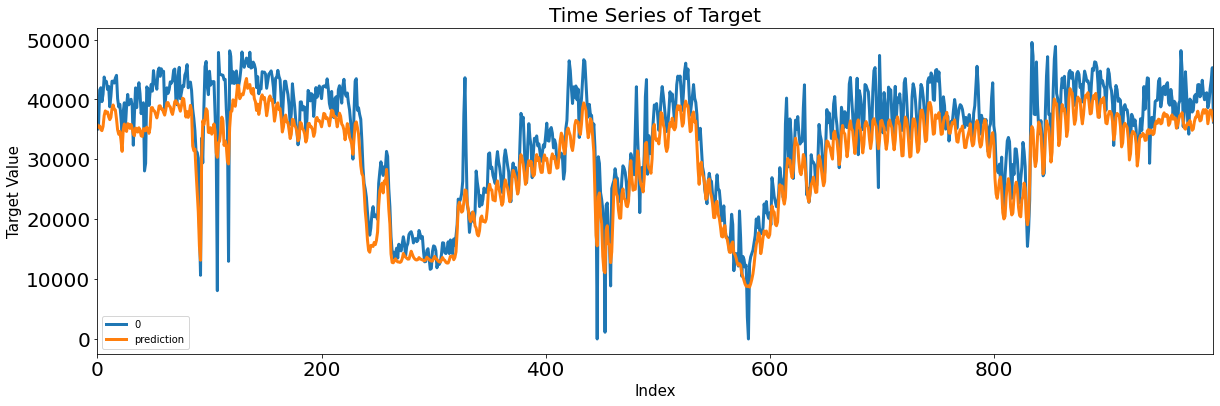

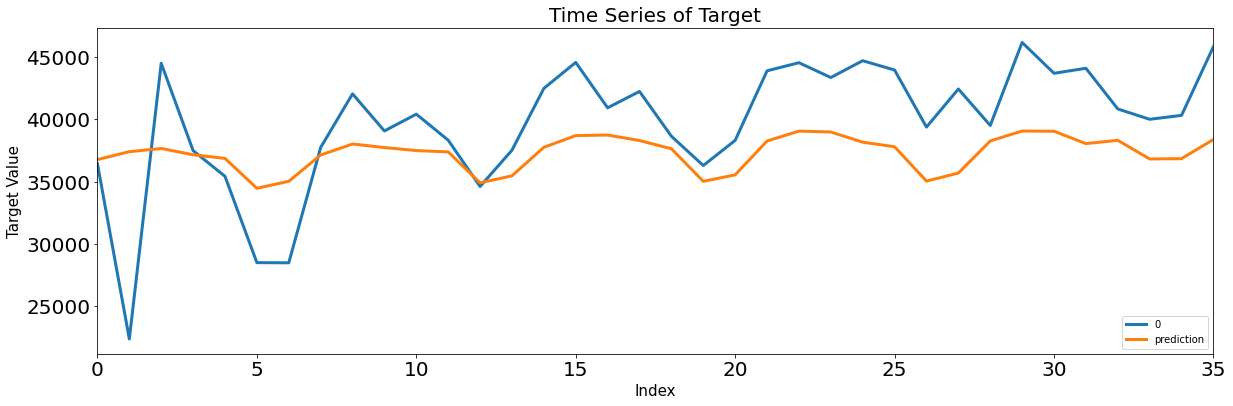

In [50]:
# LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit_lstm = model.fit(X_train_lstm, Y_train_lstm, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit_lstm.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred_lstm = model.predict(X_train_lstm)
Y_test_pred_lstm = model.predict(X_test_lstm)

# evaluation
result_lstm = model.evaluate(X_test_lstm, Y_test_pred_lstm)
if scaler_Y_tr != []:
    Y_train_lstm = scaler_Y_tr.inverse_transform(Y_train_lstm)
    Y_train_pred_lstm = scaler_Y_tr.inverse_transform(Y_train_pred_lstm)
    Y_test_lstm = scaler_Y_tr.inverse_transform(Y_test_lstm)
    Y_test_pred_lstm = scaler_Y_tr.inverse_transform(Y_test_pred_lstm)
Score_LSTM, Residual_tr_lstm, Residual_te_lstm = evaluation_trte(pd.DataFrame(Y_train_lstm), Y_train_pred_lstm.flatten(), 
                                                      pd.DataFrame(Y_test_lstm), Y_test_pred_lstm.flatten(), graph_on=True)
display(Score_LSTM)

# error analysis
#error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)

# GRU

In [51]:
# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 24
batch_sizBe = 32
epoch = 40
verbose = 1
dropout_ratio = 0.2

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

## X / Y Split
X_train_gru, Y_train_gru = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train_gru.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train_gru.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train_gru, Y_train_gru = np.array(X_train_gru), np.array(Y_train_gru)
X_test_gru, Y_test_gru = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test_gru.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test_gru.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test_gru, Y_test_gru = np.array(X_test_gru), np.array(Y_test_gru) 

print('X_train_gru:', X_train_gru.shape, 'Y_train_gru:', Y_train_gru.shape)
print('X_test_gru:', X_test_gru.shape, 'Y_test_gru:', Y_test_gru.shape)


## Retype and Reshape
X_train_gru = X_train_gru.reshape(X_train_gru.shape[0], sequence, -1)
X_test_gru = X_test_gru.reshape(X_test_gru.shape[0], sequence, -1)
print('X_train_gru:', X_train_gru.shape, 'Y_train_gru:', Y_train_gru.shape)
print('X_test_gru:', X_test_gru.shape, 'Y_test_gru:', Y_test_gru.shape)

X_train_gru: (997, 24, 54) Y_train_gru: (997, 1)
X_test_gru: (36, 24, 54) Y_test_gru: (36, 1)
X_train_gru: (997, 24, 54) Y_train_gru: (997, 1)
X_test_gru: (36, 24, 54) Y_test_gru: (36, 1)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 24, 128)           70656     
                                                                 
 dropout_16 (Dropout)        (None, 24, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 24, 256)           296448    
                                                                 
 dropout_17 (Dropout)        (None, 24, 256)           0         
                                                                 
 gru_2 (GRU)                 (None, 24, 128)           148224    
                                                                 
 dropout_18 (Dropout)        (None, 24, 128)           0         
                                                                 
 gru_3 (GRU)                 (None, 64)               

2022-06-08 15:42:12.012218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 79s 2s/step - loss: 0.0592
Epoch 2/40
32/32 [==============================] - 76s 2s/step - loss: 0.0152
Epoch 3/40
32/32 [==============================] - 75s 2s/step - loss: 0.0103
Epoch 4/40
32/32 [==============================] - 76s 2s/step - loss: 0.0099
Epoch 5/40
32/32 [==============================] - 75s 2s/step - loss: 0.0081
Epoch 6/40
32/32 [==============================] - 76s 2s/step - loss: 0.0077
Epoch 7/40
32/32 [==============================] - 75s 2s/step - loss: 0.0081
Epoch 8/40
32/32 [==============================] - 75s 2s/step - loss: 0.0088
Epoch 9/40
32/32 [==============================] - 75s 2s/step - loss: 0.0066
Epoch 10/40
32/32 [==============================] - 75s 2s/step - loss: 0.0063
Epoch 11/40
32/32 [==============================] - 74s 2s/step - loss: 0.0062
Epoch 12/40
32/32 [==============================] - 75s 2s/step - loss: 0.0062
Epoch 13/40
32/32 [==============================] - 75s 2s/

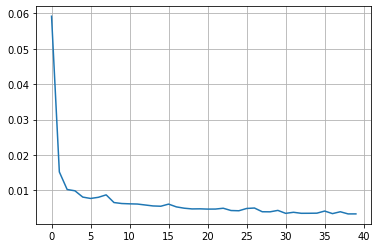

2022-06-08 16:32:27.903605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-08 16:32:33.737080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 234ms/step - loss: 0.0000e+00


,MAE,MSE,MAPE
Train,"2,603.76","10,906,497.65",inf
Test,"3,160.58","18,499,290.56",8.75


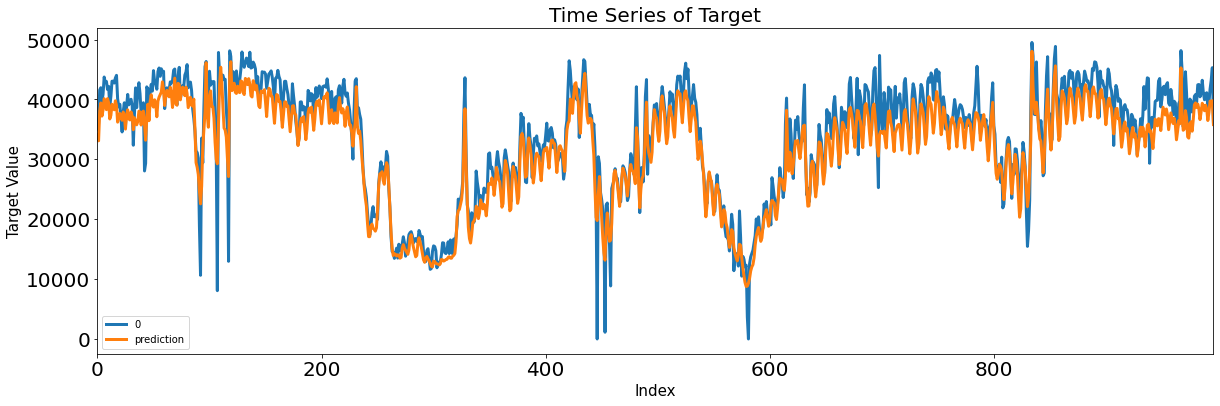

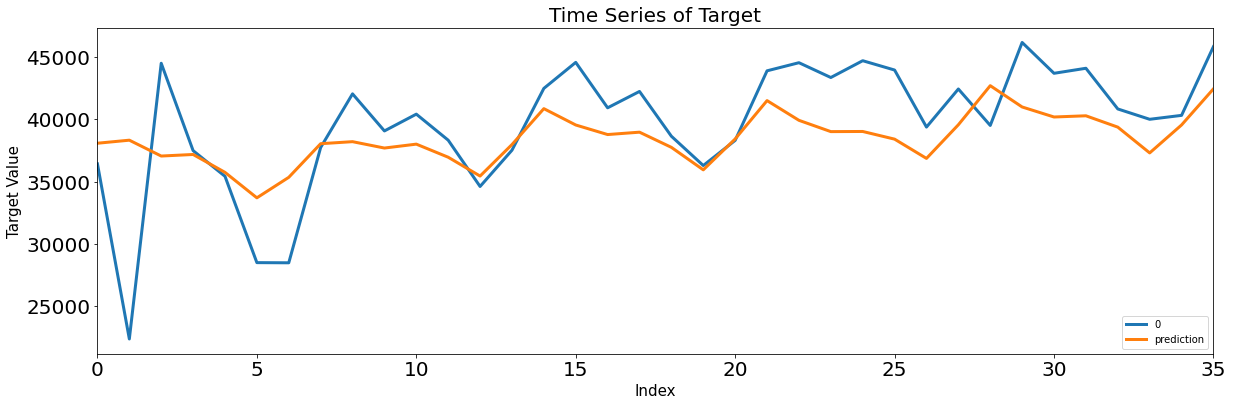

In [52]:
# GRU
model = Sequential()
model.add(GRU(128, input_shape=(X_train_gru.shape[1], X_train_gru.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit_gru = model.fit(X_train_gru, Y_train_gru, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit_gru.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred_gru = model.predict(X_train_gru)
Y_test_pred_gru = model.predict(X_test_gru)

# evaluation
result_gru = model.evaluate(X_test_gru, Y_test_pred_gru)
if scaler_Y_tr != []:
    Y_train_gru = scaler_Y_tr.inverse_transform(Y_train_gru)
    Y_train_pred_gru = scaler_Y_tr.inverse_transform(Y_train_pred_gru)
    Y_test_gru = scaler_Y_tr.inverse_transform(Y_test_gru)
    Y_test_pred_gru = scaler_Y_tr.inverse_transform(Y_test_pred_gru)
Score_GRU, Residual_tr_gru, Residual_te_gru = evaluation_trte(pd.DataFrame(Y_train_gru), Y_train_pred_gru.flatten(), 
                                                      pd.DataFrame(Y_test_gru), Y_test_pred_gru.flatten(), graph_on=True)
display(Score_GRU)
